In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from torchdiffeq import odeint_adjoint as odeint

from src.model.base_models.unet_mlp import TDFlowUnet
from src.model.flow_matching import ConditionalFlowMatching

from tqdm import tqdm

In [3]:
def generate_params(cond, d=2, weights=[0.4, 0.6]):
    mu1 = torch.tensor([0.0, 0.0, 0.0])[:d] + cond
    mu2 = torch.tensor([5.0, -10.0, 1.0])[:d] + cond

    Sigma1 = torch.tensor([[0.5, 0.1, 0.0],
                    [0.1, 0.3, 0.0],
                    [0.0, 0.0, 0.2]])[:d, :d]

    Sigma2 = torch.tensor([[1, 0.2, 0.1],
                    [0.2, 1.0, 0.3],
                    [0.1, 0.3, 1]])[:d, :d]

    means = [mu1, mu2]
    covs = [Sigma1, Sigma2]
    return weights, means, covs

def mixture_samples(n_samples, d, weights, means, covs):

    choices = torch.rand(n_samples) < weights[0]  # True = Gaussian 1, False = Gaussian 2
    samples = torch.zeros((n_samples, d))
    norm1 = torch.distributions.MultivariateNormal(means[0], covs[0])
    norm2 = torch.distributions.MultivariateNormal(means[1], covs[1])
    samples[choices] = norm1.sample((torch.sum(choices),))
    samples[~choices] = norm2.sample((torch.sum(~choices),))

    return samples

In [4]:
cond1 = torch.zeros((2))
cond2 = torch.ones((2))*10
n_samples = 10_000
d=2

In [5]:
data = torch.cat(
    [mixture_samples(n_samples, d, *generate_params(cond1)), mixture_samples(n_samples, d, *generate_params(cond2))],
    dim=0)
cond = torch.cat([torch.zeros(n_samples), torch.ones(n_samples)], dim=0).view(-1,1)

In [6]:
class ConditionalMixtureDataset(Dataset):
    def __init__(self, data, cond):
        self.data = data
        self.cond = cond
    
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        return self.data[idx], self.cond[idx]

In [7]:
dataset = ConditionalMixtureDataset(data, cond)

In [8]:
loader = DataLoader(dataset, batch_size=256, shuffle=True)

In [9]:
device = torch.device('mps')

In [10]:
unet = TDFlowUnet(state_dim=2, cond_dim=1)
fm = ConditionalFlowMatching(model=unet, obs_dim=(d,)).to(device)

In [11]:
num_epochs = 201
lr = 1e-4
optimizer = torch.optim.AdamW(fm.parameters(), lr)

In [12]:
total_loss = []
for epoch in tqdm(range(num_epochs)):
    epoch_loss = 0
    for i, (x1, cond) in enumerate(loader):
        x1 = x1.to(device)
        cond = cond.to(device)
        t = torch.rand(x1.shape[0]).to(device)
        x0 = torch.randn_like(x1).to(device)
        loss = fm.criterion(t, x0, x1, cond)
        epoch_loss += loss.detach().cpu().numpy()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    total_loss.append(epoch_loss/(i+1))
    if epoch %100 == 0:
        print(f"Total Loss Epoch {epoch+1}: ", total_loss[-1])

  0%|          | 1/201 [00:00<02:32,  1.31it/s]

Total Loss Epoch 1:  50.78465


 50%|█████     | 101/201 [00:49<00:47,  2.10it/s]

Total Loss Epoch 101:  8.372886


100%|██████████| 201/201 [01:36<00:00,  2.07it/s]

Total Loss Epoch 201:  8.308753


In [13]:
fm = fm.to('cpu')

In [14]:
n_samples = 10_000
x0 = torch.randn((n_samples,2))
cond1 = torch.zeros(n_samples).view(-1,1)
cond2 = torch.ones(n_samples).view(-1,1)

In [15]:
samples_cond1 = fm.sample(n_samples, cond1)
samples_cond2 = fm.sample(n_samples, cond2)

In [16]:
samples, cond = dataset[:]
real_datacond1 = samples[cond.squeeze()==0.]
real_datacond2 = samples[cond.squeeze()==1.]

In [17]:
assert real_datacond1.shape[0] == samples_cond1.shape[0]

In [18]:
import seaborn as sns

<Axes: xlabel='None', ylabel='None'>

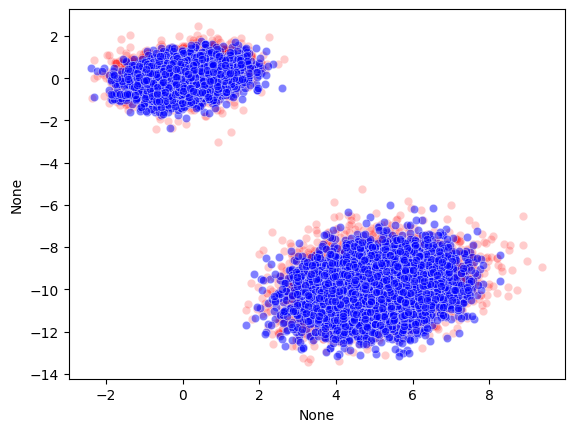

In [19]:
sns.scatterplot(
    x = samples_cond1[:, 0],
    y = samples_cond1[:, 1],
    color='r',
    alpha=0.2
)
real_datacond1
sns.scatterplot(
    x = real_datacond1[:, 0],
    y = real_datacond1[:, 1],
    color='b',
    alpha=0.5
)

<Axes: xlabel='None', ylabel='None'>

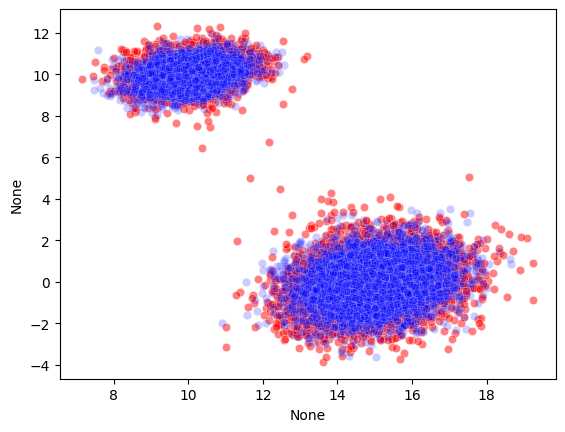

In [20]:
sns.scatterplot(
    x = samples_cond2[:, 0],
    y = samples_cond2[:, 1],
    color='r',
    alpha=0.5
)
real_datacond1
sns.scatterplot(
    x = real_datacond2[:, 0],
    y = real_datacond2[:, 1],
    color='b',
    alpha=0.2
)

<Axes: xlabel='None', ylabel='None'>

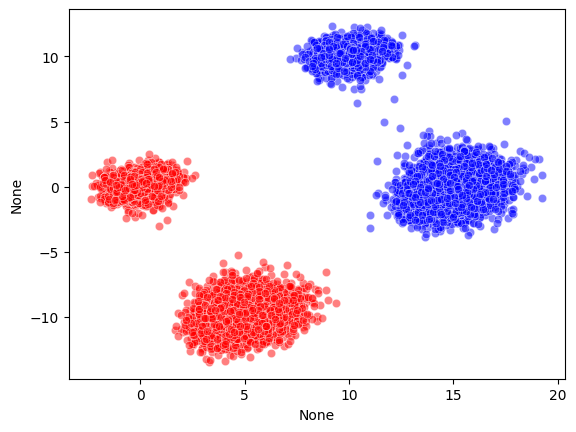

In [25]:
sns.scatterplot(
    x = samples_cond1[:, 0],
    y = samples_cond1[:, 1],
    color='r',
    alpha=0.5
)
sns.scatterplot(
    x = samples_cond2[:, 0],
    y = samples_cond2[:, 1],
    color='b',
    alpha=0.5
)

In [31]:
x1, cond = dataset[:4]


In [32]:
logp = fm.logp(x1, cond, n_samples=5)

In [33]:
import numpy as np
from scipy.stats import multivariate_normal
from scipy.special import logsumexp

def compute_gmm_logp(x, weights, means, covs):

    log_probs = []
    for i in range(len(weights)):
        lp = multivariate_normal.logpdf(x, mean=means[i], cov=covs[i])
        log_probs.append(np.log(weights[i]) + lp)
    
    return logsumexp(np.array(log_probs), axis=0)

In [34]:
weights, means, covs = generate_params(cond[0])

In [35]:
print("Estimated logp: ", logp)
print("Ground Truth: ", compute_gmm_logp(x1.numpy(), weights, means, covs))

Estimated logp:  tensor([-2.6779, -2.5064, -2.2127, -3.1849])
Ground Truth:  [-2.73521943 -2.66672369 -2.38000671 -2.96142969]
